<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b> I tried to read a license plate from images with a PaliGemma model using prompts. </span></i>


* I created <b>PaliGemma prompts</b> with tf.dataset,


## Caption Example
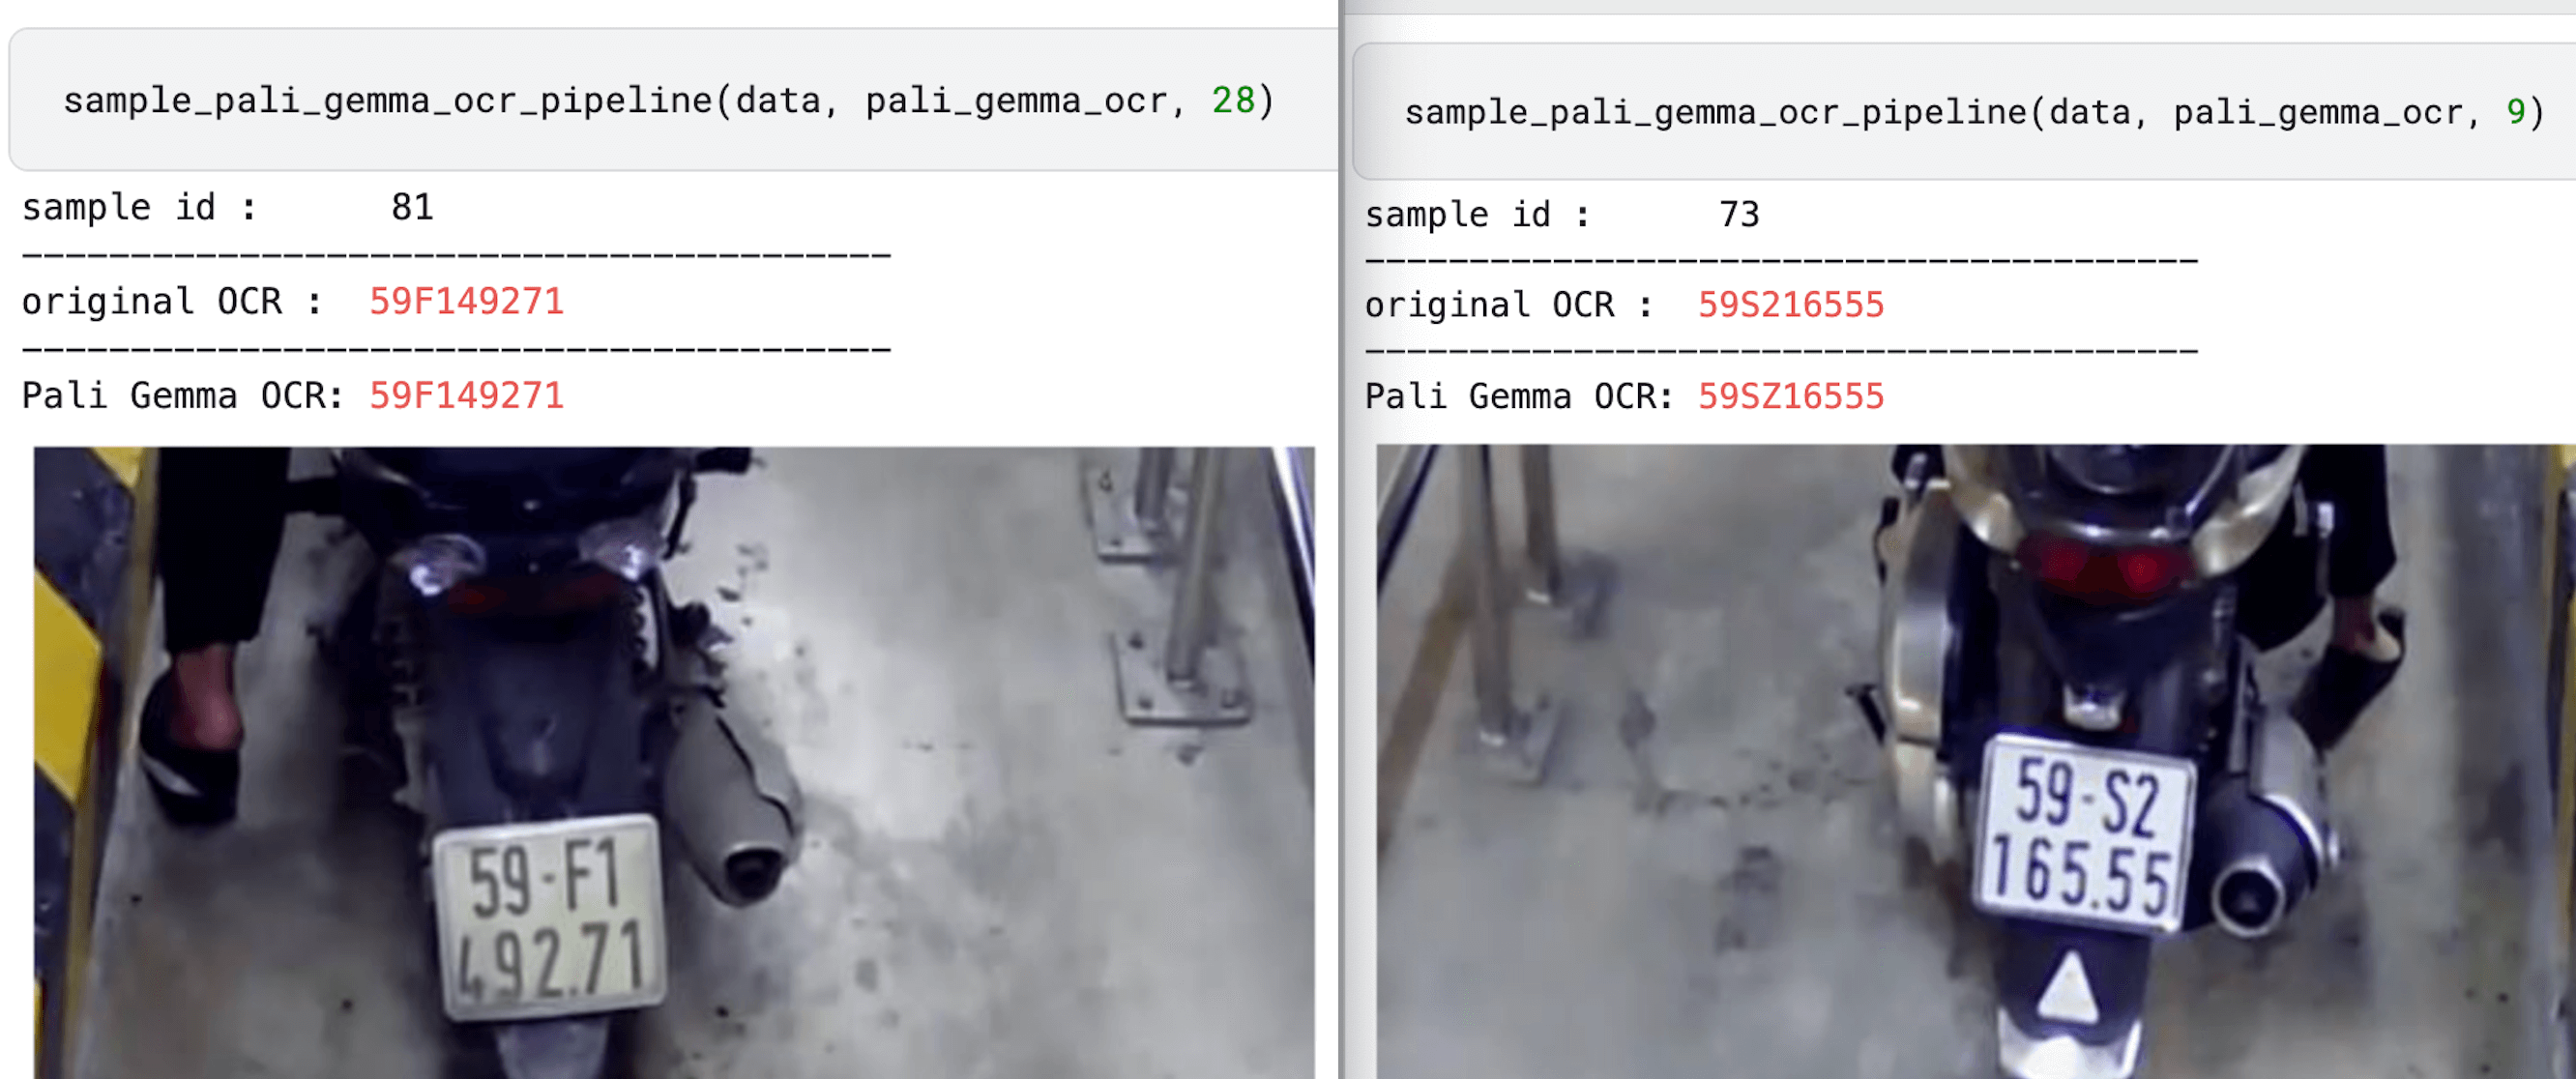

## My Another Projects
* [Depressive vs Non-depressive Tweet w/Custom FNet](https://www.kaggle.com/code/banddaniel/depressive-vs-non-depressive-tweet-w-custom-fnet)
* [Manufacturing Question-Answer w/Gemma 7B (LoRA)](https://www.kaggle.com/code/banddaniel/manufacturing-question-answer-w-gemma-7b-lora)


## References
1. https://www.kaggle.com/code/awsaf49/paligemma-quick-start

In [1]:
from IPython.display import clear_output
!pip install --upgrade pip
!pip install -q -U keras-nlp --no-deps
!pip install colorama
!pip install -q tensorflow-cpu
!pip install -q -U tensorflow-hub
!pip install -q -U keras>=3
!pip install -U tensorflow-text
clear_output()

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import pprint
import random
import cv2
import re

import jax
import keras
import keras_nlp
import tensorflow as tf
keras.config.set_floatx("bfloat16")

SEED = 24
IMG_SIZE = 224,224
clear_output()

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
# creating dataframe
img_paths = sorted(os.listdir('/kaggle/input/100-bien-so-xe-may-ocr/biensoxemayhon100bien/anh'))
ocr_paths = sorted(os.listdir('/kaggle/input/100-bien-so-xe-may-ocr/biensoxemayhon100bien/label'))

data = pd.DataFrame({'image': img_paths, 'ocr': ocr_paths})
data['image'] = '/kaggle/input/100-bien-so-xe-may-ocr/biensoxemayhon100bien/anh/' + data['image']
data['ocr'] = '/kaggle/input/100-bien-so-xe-may-ocr/biensoxemayhon100bien/label/' + data['ocr']

# a function for reading ocr from txt files
def read_ocr_from_txt(ocr_txt_path):
    file = open(ocr_txt_path, "r")
    content = file.read()
    content = re.split("\n", content)[0]
    file.close()
    return content

data['ocr'] = data['ocr'].apply(read_ocr_from_txt)

data.head()

,image,ocr
0,/kaggle/input/100-bien-so-xe-may-ocr/biensoxem...,59E12150
1,/kaggle/input/100-bien-so-xe-may-ocr/biensoxem...,59L206377
2,/kaggle/input/100-bien-so-xe-may-ocr/biensoxem...,59C165331
3,/kaggle/input/100-bien-so-xe-may-ocr/biensoxem...,59T108264
4,/kaggle/input/100-bien-so-xe-may-ocr/biensoxem...,52U78693


# <span style="color:#e74c3c;"> PaliGemma 3B </span> Model

In [4]:
pali_gemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")
clear_output()

# <span style="color:#e74c3c;"> Create tf.data </span> Pipeline

In [5]:
# i don't use caption in this step

def img_preprocessing(img_path, caption):
    prompt = 'ocr\n'

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size = (IMG_SIZE))
    
    return {'images': img, 'prompts': prompt}

In [6]:
# creating dataset

ds_loader = tf.data.Dataset.from_tensor_slices((data['image'], data['ocr']))
ds = (ds_loader.map(img_preprocessing, num_parallel_calls = tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE))

# <span style="color:#e74c3c;"> Generation </span>

In [7]:
pali_gemma_ocr = pali_gemma.generate(ds)

# <span style="color:#e74c3c;"> Licanse Plate OCR </span> Pipeline

In [8]:
def sample_pali_gemma_ocr_pipeline(original_df : pd.DataFrame, generated_ocr_arr : np.array, SEED: int = None):
    
    idx = np.random.default_rng(seed=SEED).permutation(original_df.shape[0])[0]
    img = cv2.imread(original_df.iloc[idx].image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    
    print("sample id :\t", idx)
    print("--"*20)
    print("original OCR :\t" +Fore.RED + original_df.iloc[idx].ocr + Style.RESET_ALL)
    print("--"*20)
    
    # pali gemma ocr
    pali_gemma_ocr_ = re.split("\n", pali_gemma_ocr[idx])[1]
    pali_gemma_ocr_ = re.sub('[.\- ]', '', pali_gemma_ocr_)
    print("Pali Gemma OCR:\t" +Fore.RED + pali_gemma_ocr_ + Style.RESET_ALL)

# <span style="color:#e74c3c;"> OCR  </span> Examples

sample id :	 81
----------------------------------------
original OCR :	59F149271
----------------------------------------
Pali Gemma OCR:	59F149271


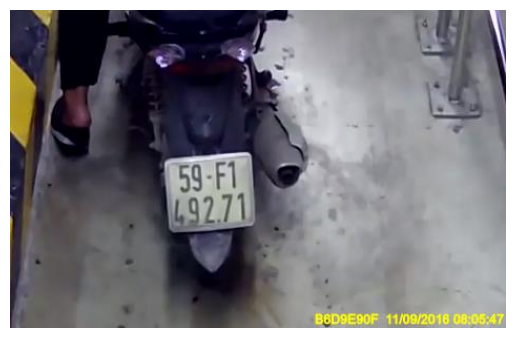

In [9]:
sample_pali_gemma_ocr_pipeline(data, pali_gemma_ocr, 28)

sample id :	 38
----------------------------------------
original OCR :	59K190300
----------------------------------------
Pali Gemma OCR:	59K190300


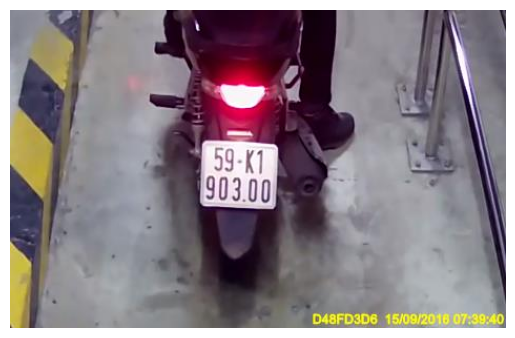

In [10]:
sample_pali_gemma_ocr_pipeline(data, pali_gemma_ocr, 87)

sample id :	 73
----------------------------------------
original OCR :	59S216555
----------------------------------------
Pali Gemma OCR:	59SZ16555


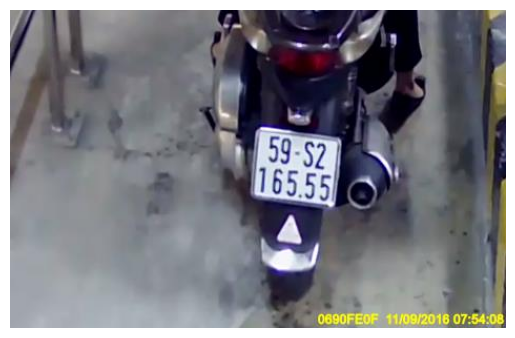

In [11]:
sample_pali_gemma_ocr_pipeline(data, pali_gemma_ocr, 9)

sample id :	 76
----------------------------------------
original OCR :	59C159610
----------------------------------------
Pali Gemma OCR:	59C152610


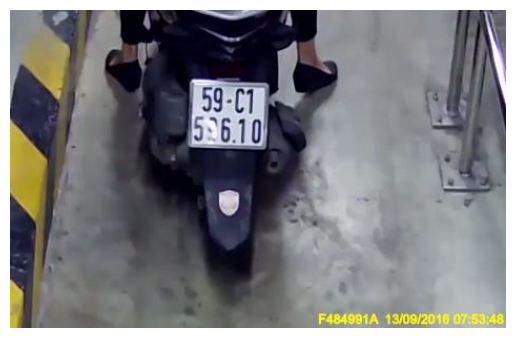

In [12]:
sample_pali_gemma_ocr_pipeline(data, pali_gemma_ocr, 12)